In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from src.paths import RAW_DATA_DIR, PREPROCESSED_DATA_DIR

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

#### Read data

In [3]:
data_train = pd.read_csv(RAW_DATA_DIR / 'train.csv')
data_test = pd.read_csv(RAW_DATA_DIR / 'test.csv')

# keep both dataframes in one list as we will be applying same transformations to both of them
data_frames = [data_train, data_test]
data_names = ['train', 'test']

for df, name in zip(data_frames, data_names):
    print(f'\n--- {name} data ---\nNumber of rows: {df.shape[0]}\nColumns: {df.columns.to_list()}')
    print(f'Number of nans: {df.isna().sum().sum()}')


--- train data ---
Number of rows: 10506
Columns: ['Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent']
Number of nans: 0

--- test data ---
Number of rows: 116293
Columns: ['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy']
Number of nans: 0


#### Keep relevant columns
We will drop all the address columns. Trap id and coordinates are sufficient location data. We also ignore number of mosquitos in training data, as it is not given in the test set and virus presence prediction should made before any mosquitos are catched. 

In [4]:
for df in data_frames:
    df.drop(['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], axis=1, inplace=True)
    
data_train.drop(['NumMosquitos'], axis=1, inplace=True)

In [5]:
# print columns
for df, name in zip(data_frames, data_names):
    print(f'\n--- {name} data ---\nColumns: {df.columns.to_list()}')


--- train data ---
Columns: ['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'WnvPresent']

--- test data ---
Columns: ['Id', 'Date', 'Species', 'Trap', 'Latitude', 'Longitude']


#### Data types

In [6]:
# inspect data types in dataframes
for df, name in zip(data_frames, data_names):
    print(f'\t{name} data:\n{df.dtypes}\n')

	train data:
Date           object
Species        object
Trap           object
Latitude      float64
Longitude     float64
WnvPresent      int64
dtype: object

	test data:
Id             int64
Date          object
Species       object
Trap          object
Latitude     float64
Longitude    float64
dtype: object



In [7]:
# change 'Date' column format to 'datetime64'
for df in data_frames:
    df['Date'] = pd.to_datetime(df['Date'])

Data types of columns 'Trap' and 'Species' will be addressed later. 

#### Target variable - 'WnvPresent'
0 - virus not present in the sample

1 - virus present in the sample

In [8]:
classes = data_train.WnvPresent.value_counts().to_frame()
classes['percent'] = (classes['count']/classes['count'].sum()*100).round(2).astype('str')+'%'
display(classes)


,count,percent
WnvPresent,,
0,9955,94.76%
1,551,5.24%


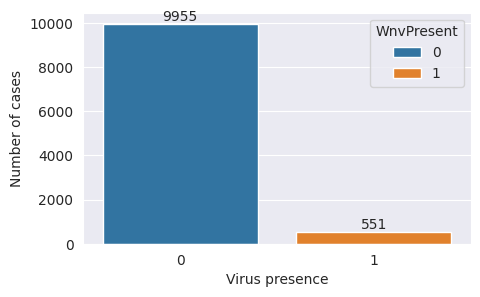

In [9]:
# plot counts of positive and negative cases
plt.figure(figsize=(5,3))
ax = sns.barplot(classes, x='WnvPresent', y='count', hue='WnvPresent')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.set_xlabel('Virus presence')
ax.set_ylabel('Number of cases')
plt.show()

The target classes are highly imbalanced. We will resample data for training. Area under the ROC curve is an appropriate evaluation metric in this case.

### Species

Let's look at virus distribution among different species.

In [10]:
species = data_train.Species.value_counts().to_frame()
species['wnv_present_cnt'] = data_train.groupby('Species').WnvPresent.sum()
species['wnv_present_pct'] = (data_train.groupby('Species').WnvPresent.mean()*100).round(2).astype('str')+'%'
display(species)

,count,wnv_present_cnt,wnv_present_pct
Species,,,
CULEX PIPIENS/RESTUANS,4752,262,5.51%
CULEX RESTUANS,2740,49,1.79%
CULEX PIPIENS,2699,240,8.89%
CULEX TERRITANS,222,0,0.0%
CULEX SALINARIUS,86,0,0.0%
CULEX TARSALIS,6,0,0.0%
CULEX ERRATICUS,1,0,0.0%


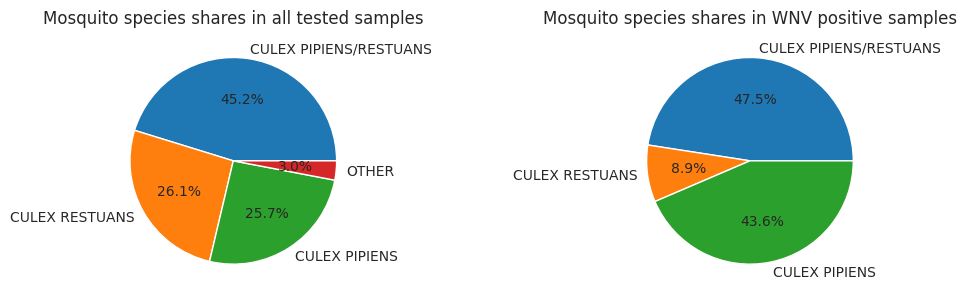

In [11]:
# visualize mosquito species shares among gathered samples

fig, ax = plt.subplots(1,2, figsize=(10,20))
plt.subplots_adjust(wspace=1)

# gather least frequent species into one category 'OTHER'
species_with_other = species[species.wnv_present_cnt!=0]
species_with_other.loc['OTHER'] = [species[species.wnv_present_cnt==0]['count'].sum(), 0,0]

ax[0].pie(species_with_other['count'], labels=species_with_other.index, autopct='%1.1f%%')
ax[0].set_title('Mosquito species shares in all tested samples')

species_positive = species[species.wnv_present_cnt!=0]

ax[1].pie(species_positive['wnv_present_cnt'], labels=species_positive.index, autopct='%1.1f%%')
ax[1].set_title('Mosquito species shares in WNV positive samples')

plt.show()


We can see that there are 3 main species occuring in large numbers and being infected at some point. We will remove remaining 4 species from our data and assign '0' to all data instances for these 4 species during evaluation.

In [12]:
positive_species = list(species[species.wnv_present_cnt!=0].index)

species2index = {
    positive_species[i]: i for i in range(len(positive_species))
}

for i in range(2):
    data_frames[i] = data_frames[i][data_frames[i]['Species'].isin(positive_species)]
    data_frames[i]['Species'] = data_frames[i]['Species'].map(species2index)


#### Dates
Now we inspect West Nile virus presence across available time span.

In [13]:
# extract date components from 'Date' column
def split_date(df):
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Week'] = df.Date.dt.isocalendar().week
    df['Dayofweek'] = df['Date'].dt.dayofweek
    df['Dayofyear'] = df['Date'].dt.dayofyear

for df in data_frames:
    split_date(df)

Let's look closer at numbers of virus positive cases across years, months and weeks.

In [14]:
for col in ['Month', 'Year', 'Week']:
    display(
        data_frames[0].groupby(col).agg(
            positive_cases = ('WnvPresent', 'sum'),
            percent = ('WnvPresent', lambda x: (x.mean()*100).round(2))
        )
    )

,positive_cases,percent
Month,,
5,0,0.00
6,1,0.07
7,46,1.82
8,377,10.36
9,125,5.82
10,2,0.76


,positive_cases,percent
Year,,
2007,236,6.45
2009,19,0.86
2011,57,2.94
2013,239,10.04


,positive_cases,percent
Week,,
22,0,0.00
23,0,0.00
24,0,0.00
25,0,0.00
26,1,0.20
27,0,0.00
28,7,0.74
29,16,2.77
30,20,2.79


In [15]:
year_week_cases = data_frames[0].groupby(['Year', 'Week']).agg(
    positive_cases = ('WnvPresent', 'sum'),
    percent = ('WnvPresent', lambda x: (x.mean()*100).round(2))
).reset_index()
year_week_cases['year-week'] = year_week_cases['Year'].astype('str')+'_w'+year_week_cases['Week'].astype('str')
year_week_cases.set_index('year-week', inplace=True)

In [16]:
all_weeks = [f'{y}_w{w}' for y in range(2007, 2014, 2) for w in range(20,45)]
df_all_weeks = pd.DataFrame(index=all_weeks)

year_week_cases = pd.merge(df_all_weeks, year_week_cases, left_index=True, right_index=True, how='left')
year_week_cases['Year']=year_week_cases.index.str[:4].astype('int')

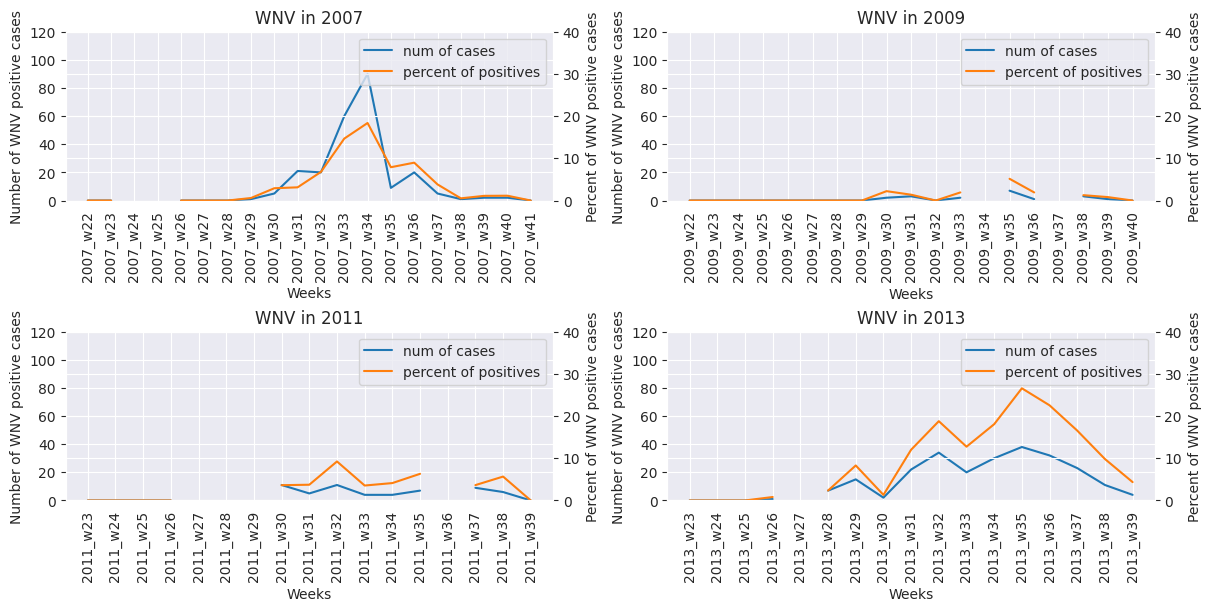

In [17]:
from itertools import product

fig, ax = plt.subplots(2,2,figsize=(12,6), constrained_layout=True)

for i, j in product(range(2), repeat=2):
    ax[i,j].plot(year_week_cases[year_week_cases['Year']==2007+4*i+2*j]['positive_cases'], label='num of cases')
    ax[i,j].set_xticklabels(ax[i,j].get_xticklabels(), rotation=90)    
    ax[i,j].set_xlabel('Weeks')
    ax[i,j].set_ylabel('Number of WNV positive cases')
    ax[i,j].set_ylim([0,120])
    ax[i,j].set_title(f'WNV in {2007+4*i+2*j}')
    bx = ax[i,j].twinx()
    bx.plot(year_week_cases[year_week_cases['Year']==2007+4*i+2*j]['percent'], label='percent of positives', color='#ff7f0e')
    bx.set_ylabel('Percent of WNV positive cases')
    bx.set_ylim([0,40])
    lines, labels = ax[i,j].get_legend_handles_labels()
    lines2, labels2 = bx.get_legend_handles_labels()
    bx.legend(lines + lines2, labels + labels2, loc=0)

plt.show()

Significant amounts of infections were recorded in the summer months from July to September. Again, we will limit our data to these 3 months and remove other. We will predict '0' to all test instances not in July-September period. 

In [18]:
possible_months = [7,8,9]

for i in range(2):
    data_frames[i] = data_frames[i][data_frames[i]['Month'].isin(possible_months)]

#### Traps

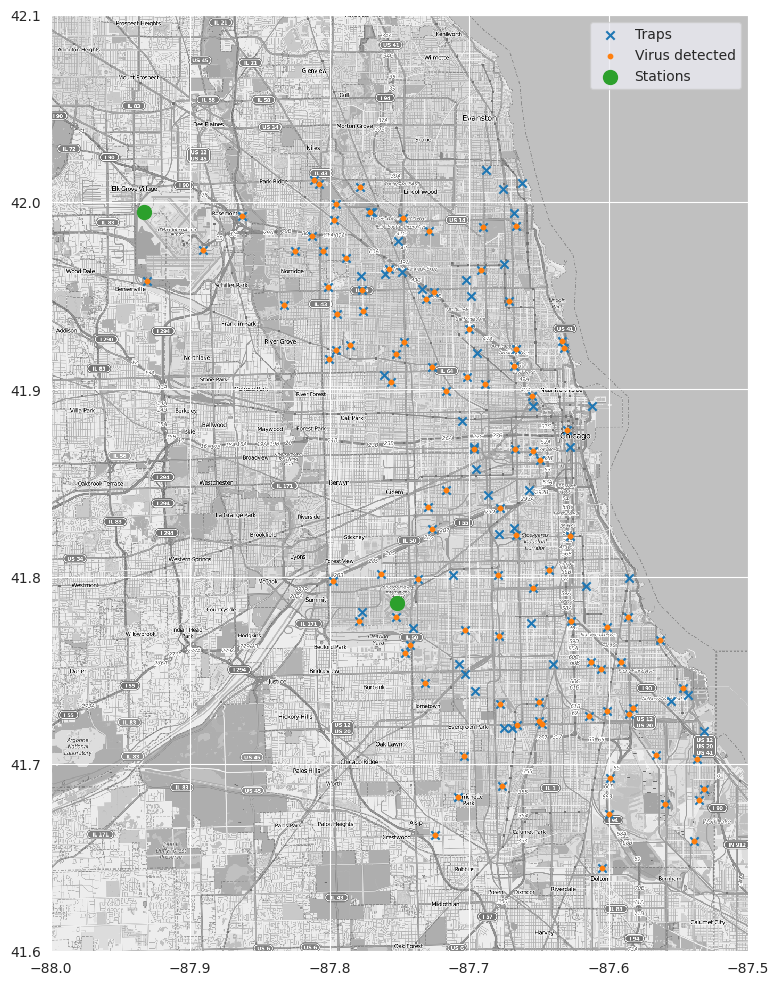

In [19]:
data_train = data_frames[0]
stations = np.array([[-87.933, 41.995],[-87.752, 41.786]])
locations = data_train[['Longitude', 'Latitude']].drop_duplicates().values
locations_wnv = data_train[data_train.WnvPresent!=0][['Longitude', 'Latitude']].drop_duplicates().values

image_arr = np.loadtxt(RAW_DATA_DIR / 'mapdata_copyright_openstreetmap_contributors.txt')
plt.figure(figsize=(9,13))
plt.imshow(image_arr, interpolation='nearest', cmap='gray', extent=(-88, -87.5, 41.6, 42.1), aspect=image_arr.shape[0]/image_arr.shape[1])
plt.scatter(locations[:,0], locations[:,1], marker='x', label='Traps')
plt.scatter(locations_wnv[:,0], locations_wnv[:,1], marker='o', s=10, label='Virus detected')
plt.scatter(stations[:,0], stations[:,1], marker='o', s=100, label='Stations')
plt.legend()
plt.show()

Many traps never caught any infected mosquito. We will predict '0' for those traps in the data set.

In [20]:
possible_traps = data_train[data_train.WnvPresent!=0].Trap.unique()

for i in range(2):
    data_frames[i] = data_frames[i][data_frames[i].Trap.isin(possible_traps)]

In [21]:
data_frames[0].shape[0], data_frames[1].shape[0]

(7428, 23734)

In [22]:
data_train = data_frames[0]

trap_scores = data_train.groupby('Trap')['WnvPresent'].agg(['sum', 'mean']).rename(columns={'sum': 'cnt', 'mean': 'pct'})
display(trap_scores.sort_values('cnt', ascending=False).head(20))
trap_scores.sort_values('pct', ascending=False).head(20)

,cnt,pct
Trap,,
T900,66,0.125475
T115,41,0.082828
T002,18,0.127660
T138,16,0.055556
T003,14,0.142857
T128,11,0.082707
T011,11,0.104762
T225,11,0.118280
T008,10,0.094340


,cnt,pct
Trap,,
T143,6,0.260870
T006,4,0.210526
T005,2,0.166667
T233,7,0.162791
T096,6,0.162162
T014,4,0.153846
T015,4,0.153846
T235,7,0.145833
T003,14,0.142857


## Cleaning weather data

In [23]:
weather = pd.read_csv(RAW_DATA_DIR / 'weather.csv')

print(f'\n---WEATHER DATA---\nNumber of rows: {weather.shape[0]}\nColumns: {weather.columns.to_list()}\n')

print(f'Number of "M": {(weather=="M").sum().sum()}')


---WEATHER DATA---
Number of rows: 2944
Columns: ['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']

Number of "M": 7415


In [24]:
columns_to_stay = ['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'CodeSum','PrecipTotal']
weather = weather[columns_to_stay]

# look closer at missing values in weather data
missing_weather = pd.DataFrame((weather=='M').sum(), columns=['number'])
missing_weather['percent'] = (missing_weather.number/weather.shape[0]*100).round(1)
missing_weather

,number,percent
Station,0,0.0
Date,0,0.0
Tmax,0,0.0
Tmin,0,0.0
Tavg,11,0.4
DewPoint,0,0.0
WetBulb,4,0.1
CodeSum,0,0.0
PrecipTotal,2,0.1


In [25]:

weather.Tavg = np.where(
    weather.Tavg == 'M',
    weather[['Tmax', 'Tmin']].mean(axis=1),
    weather.Tavg
).astype('int')

weather[weather.WetBulb=='M']

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal
848,1,2009-06-26,86,69,78,60,M,,0.00
2410,1,2013-08-10,81,64,73,57,M,,0.00
2412,1,2013-08-11,81,60,71,61,M,RA,0.01
2415,2,2013-08-12,85,69,77,63,M,RA,0.66


In [26]:
from sklearn.linear_model import LinearRegression


lr = LinearRegression()

train_weather = weather[weather.WetBulb!='M'][['Tmax', 'Tmin', 'DewPoint', 'WetBulb']]
test_weather = weather[weather.WetBulb=='M'][['Tmax', 'Tmin', 'DewPoint']]
y_train = train_weather.pop('WetBulb').astype(float)
X_train = train_weather
X_test = test_weather

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

missing_index = weather[weather.WetBulb=='M'].index
weather.loc[missing_index, 'WetBulb'] = y_pred.round()

weather.WetBulb = weather.WetBulb.astype(float)

weather[weather.PrecipTotal=='M']

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal
117,2,2007-06-28,73,61,67,56,61.0,,M
119,2,2007-06-29,71,56,64,56,60.0,,M


In [27]:
missing_dates = weather[weather.PrecipTotal=='M'].Date
missing_dates
weather[weather.Date.isin(missing_dates)]

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal
116,1,2007-06-28,74,58,66,55,60.0,,0.00
117,2,2007-06-28,73,61,67,56,61.0,,M
118,1,2007-06-29,70,56,63,55,59.0,,0.00
119,2,2007-06-29,71,56,64,56,60.0,,M


In [28]:
no_precip1_dates = weather[(weather.PrecipTotal=='0.00')&(weather.Station==1)].Date

weather[
    (weather.Station==2)&
    (weather.Date.isin(no_precip1_dates))&
    (weather.PrecipTotal!='0.00')&
    (weather.CodeSum==' ')&
    (weather.Date.str[-4]=='6')]

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal
117,2,2007-06-28,73,61,67,56,61.0,,M
119,2,2007-06-29,71,56,64,56,60.0,,M
1173,2,2010-06-04,83,60,72,59,64.0,,T
1961,2,2012-06-30,89,70,80,68,72.0,,T
2667,2,2014-06-15,86,64,75,58,65.0,,T


In [29]:
weather.drop('CodeSum', axis=1, inplace=True)
weather.PrecipTotal = weather.PrecipTotal.str.strip().str.replace('T', '0.001').str.replace('M', '0.001').astype('float')
weather.Date = pd.to_datetime(weather.Date)
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                    int64
DewPoint                int64
WetBulb               float64
PrecipTotal           float64
dtype: object

In [30]:
weather_st1 = weather[weather.Station==1].drop('Station', axis=1)
weather_st2 = weather[weather.Station==2].drop('Station', axis=1)
weather = weather_st1.merge(weather_st2, on='Date', suffixes=['_1', '_2'])

In [31]:
weather.head()

,Date,Tmax_1,Tmin_1,Tavg_1,DewPoint_1,WetBulb_1,PrecipTotal_1,Tmax_2,Tmin_2,Tavg_2,DewPoint_2,WetBulb_2,PrecipTotal_2
0,2007-05-01,83,50,67,51,56.0,0.000,84,52,68,51,57.0,0.000
1,2007-05-02,59,42,51,42,47.0,0.000,60,43,52,42,47.0,0.000
2,2007-05-03,66,46,56,40,48.0,0.000,67,48,58,40,50.0,0.000
3,2007-05-04,66,49,58,41,50.0,0.001,78,51,64,42,50.0,0.000
4,2007-05-05,66,53,60,38,49.0,0.001,66,54,60,39,50.0,0.001


### Weather by weeks

In [32]:
split_date(weather)

In [33]:
weather.columns

Index(['Date', 'Tmax_1', 'Tmin_1', 'Tavg_1', 'DewPoint_1', 'WetBulb_1',
       'PrecipTotal_1', 'Tmax_2', 'Tmin_2', 'Tavg_2', 'DewPoint_2',
       'WetBulb_2', 'PrecipTotal_2', 'Month', 'Year', 'Week', 'Dayofweek',
       'Dayofyear'],
      dtype='object')

In [34]:
year_week_weather = weather[weather['Year'].isin([2007, 2009, 2011, 2013])].groupby(['Year', 'Week'])[['PrecipTotal_2', 'Tmax_2']].agg('mean').reset_index()
year_week_weather['year-week'] = year_week_weather['Year'].astype('str')+'_w'+year_week_weather['Week'].astype('str')
year_week_weather.set_index('year-week', inplace=True)
year_week_weather['Tmax_2_adj'] = year_week_weather['Tmax_2']/100

In [35]:
year_week_weather = pd.merge(df_all_weeks, year_week_weather, left_index=True, right_index=True, how='left')
year_week_weather['Year']=year_week_weather.index.str[:4].astype('int')
year_week_weather

,Year,Week,PrecipTotal_2,Tmax_2,Tmax_2_adj
2007_w20,2007,20,0.111429,73.714286,0.737143
2007_w21,2007,21,0.064429,79.142857,0.791429
2007_w22,2007,22,0.151571,82.428571,0.824286
2007_w23,2007,23,0.083000,77.285714,0.772857
2007_w24,2007,24,0.023000,87.714286,0.877143
...,...,...,...,...,...
2013_w40,2013,40,0.220000,77.571429,0.775714
2013_w41,2013,41,0.001429,71.857143,0.718571
2013_w42,2013,42,0.041571,57.714286,0.577143
2013_w43,2013,43,0.008714,49.571429,0.495714


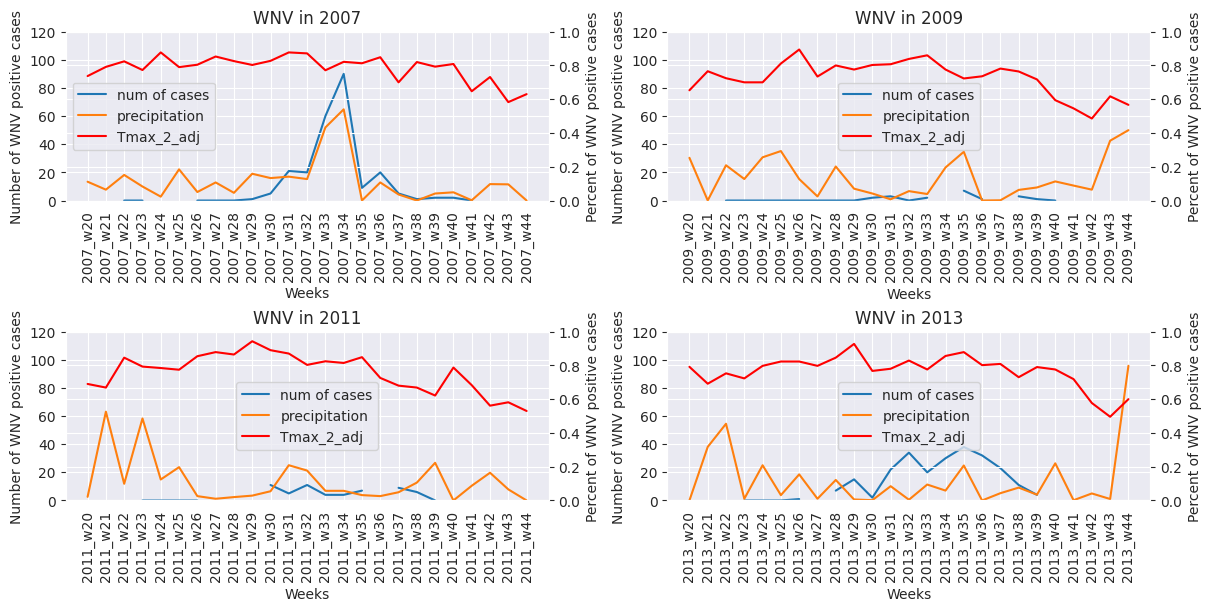

In [36]:
fig, ax = plt.subplots(2,2,figsize=(12,6), constrained_layout=True)

for i, j in product(range(2), repeat=2):
    ax[i,j].plot(year_week_cases[year_week_cases['Year']==2007+4*i+2*j]['positive_cases'], label='num of cases')
    # ax[i,j].plot(year_week_weather[year_week_cases['Year']==2007+4*i+2*j]['Tmax_2_adj'], label='Tmax_2_adj', color='r')
    ax[i,j].set_xticklabels(ax[i,j].get_xticklabels(), rotation=90)    
    ax[i,j].set_xlabel('Weeks')
    ax[i,j].set_ylabel('Number of WNV positive cases')
    ax[i,j].set_ylim([0,120])
    ax[i,j].set_title(f'WNV in {2007+4*i+2*j}')
    bx = ax[i,j].twinx()
    bx.plot(year_week_weather[year_week_cases['Year']==2007+4*i+2*j]['PrecipTotal_2'], label='precipitation', color='#ff7f0e')
    bx.plot(year_week_weather[year_week_cases['Year']==2007+4*i+2*j]['Tmax_2_adj'], label='Tmax_2_adj', color='r')
    bx.set_ylabel('Percent of WNV positive cases')
    bx.set_ylim([0,1])
    lines, labels = ax[i,j].get_legend_handles_labels()
    lines2, labels2 = bx.get_legend_handles_labels()
    bx.legend(lines + lines2, labels + labels2, loc=0)

plt.show()

In [37]:
data_train.head()

,Date,Species,Trap,Latitude,Longitude,WnvPresent,Month,Year,Week,Dayofweek,Dayofyear
201,2007-07-02,0,T002,41.954690,-87.800991,0,7,2007,27,0,183
202,2007-07-02,1,T002,41.954690,-87.800991,0,7,2007,27,0,183
205,2007-07-02,0,T015,41.974089,-87.824812,0,7,2007,27,0,183
206,2007-07-02,0,T045,41.921600,-87.666455,0,7,2007,27,0,183
207,2007-07-02,1,T045,41.921600,-87.666455,0,7,2007,27,0,183
